<a href="https://colab.research.google.com/github/fares-mldev/uns-ml2021/blob/main/tp4/ML_TP4_Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [1]:
#@title General settings

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Requirements
!pip install wget

import numpy as np


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=ffcbdb8847fcfba953dc53cbdb30e2a6434fa0f43c2aa023fbe2e3f2bc5eeab8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
#@title Model validation { run: "auto" }

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def calc_metrics(y_true, y_pred) -> dict:
  '''
  Evaluate metrics and return them in a dictionary
  '''
  metrics = {}
  metrics['accuracy']=accuracy_score(y_true,y_pred)
  metrics['f1_score']=f1_score(y_true,y_pred, average ='micro')
  metrics['precision']=precision_score(y_true,y_pred, average ='micro')
  metrics['recall']=recall_score(y_true,y_pred, average ='micro')

  return metrics

metrics = {}


In [3]:
#@title Download data

# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)


--2021-10-20 20:08:43--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip’

data_1.zip          100%[===================>]  30.59M   151MB/s    in 0.2s    

2021-10-20 20:08:43 (151 MB/s) - ‘dataroot/data_1.zip’ saved [32074743/32074743]

--2021-10-20 20:08:43--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.19

In [4]:
#@title Load data

# Load sign names
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
class_names = pd.Series(df.SignName.values,index=df.ClassId).to_dict()

# Load images
import pickle

data = {}

data['train'] = pickle.load( open( dataroot+"train.p", "rb" ) )
print("train data loaded...")
data['val'] = pickle.load( open( dataroot+"valid.p", "rb" ) )
print("validation data loaded...")
data['test'] = pickle.load( open( dataroot+"test.p", "rb" ) )
print("test data loaded...")


train data loaded...
validation data loaded...
test data loaded...


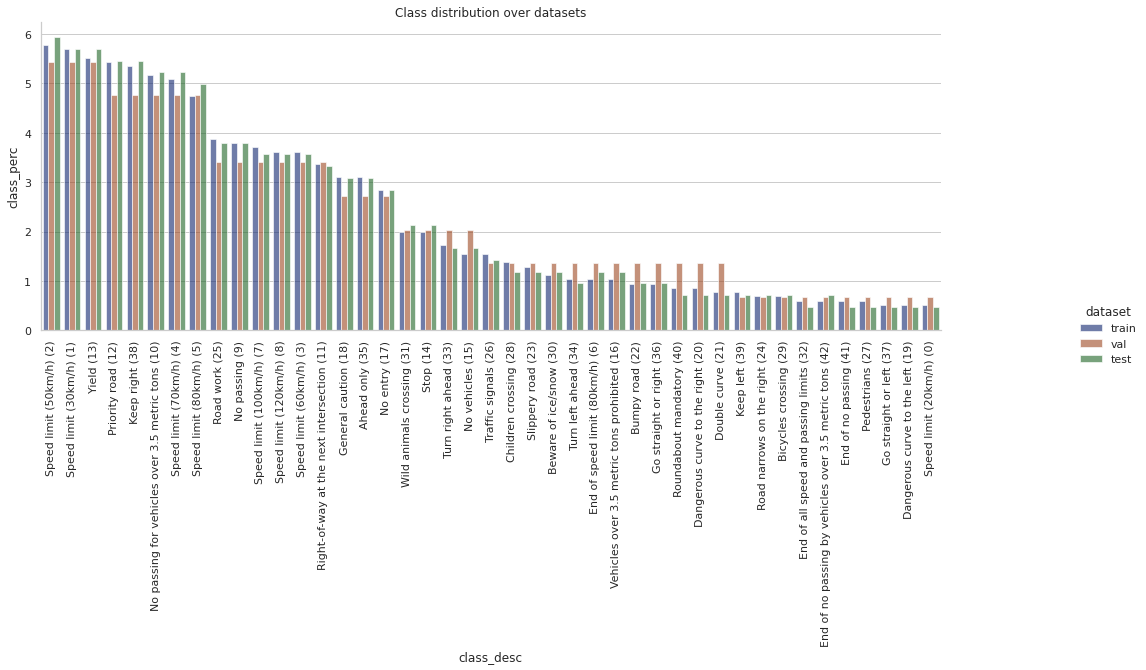

In [5]:
#@title Look for class distribution
#@markdown There is a data distribution skew. 
#@markdown The majority classes have up to 10x more representation than minority classes.
#@markdown The skew is consistent over different datasets.

import matplotlib.pyplot as plt

def class_distribution(data):

  # Build a dataframe
  # dataset | class_id | class_name             | class_count
  # 'train' | 0        | 'Speed limit (20km/h)' | 2034
  #   ...   |
  # 'test'  | 0        | 'Speed limit (20km/h)' | 345
  #   ...   |
  # 'val'   | 0        | 'Speed limit (20km/h)' | 654

  record_list = []

  # Loop over datasets
  for dataset in data:
    # Get class counts
    df_labels = pd.DataFrame(data[dataset], columns= ['labels'])
    class_counts = df_labels['labels'].value_counts()
    
    for class_id, class_count in class_counts.items():
      
      # Get class name
      class_name = class_names[class_id]

      # Build a dict for each record the following keys:
      record = {'dataset': dataset, 
                'class_id': class_id,
                'class_name': class_name,
                'class_count': class_count}

      # Append to list
      record_list.append(record)

  df_datadist = pd.DataFrame(record_list)

  # Add total count for each dataset
  df_total_counts = df_datadist.groupby('dataset').sum()['class_count']
  df_total_counts.name = 'total_count'
  df_datadist = df_datadist.join(df_total_counts,on='dataset')

  # Add percentage of class in each database 
  def calc_perc(x):
      return 100 * x['class_count'] / x['total_count'] 

  df_datadist['class_perc'] = df_datadist.apply(calc_perc, axis=1)

  # Add description
  def concat(x):
      return x['class_name'] + ' (' + str(x['class_id']) + ')'

  df_datadist['class_desc'] = df_datadist.apply(concat, axis=1)    

  return df_datadist


# Draw a nested barplot by species and sex
import seaborn as sns
sns.set_theme(style="whitegrid")

df_datadist = class_distribution(data)

# Plot data distribution percentages
g = sns.catplot(
    data=df_datadist, kind="bar",
    x="class_desc", y="class_perc", hue="dataset",
    ci="dataset", palette="dark", alpha=.6, height=6,
)

fig = plt.gcf()
fig.set_size_inches(20,5)
ax = plt.gca()
ax.set_title('Class distribution over datasets')
g.set_xticklabels(rotation=90)


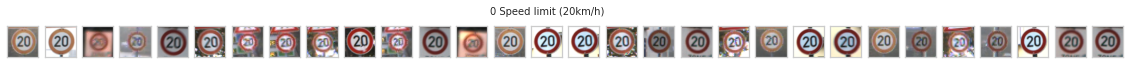

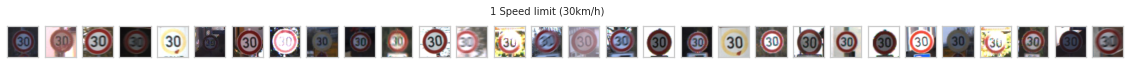

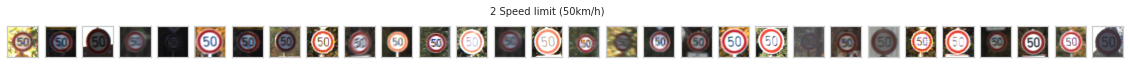

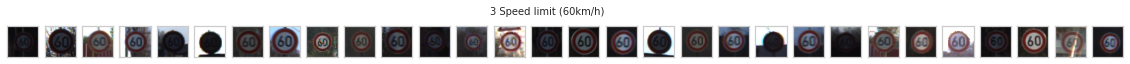

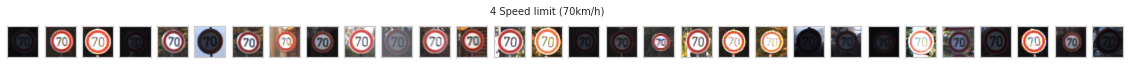

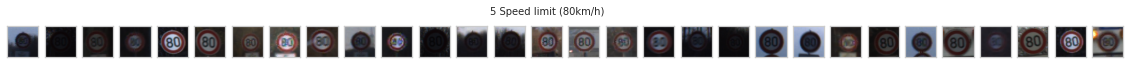

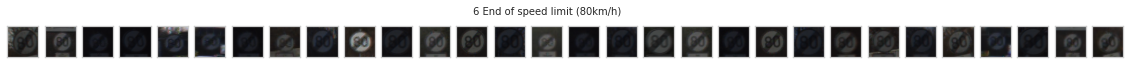

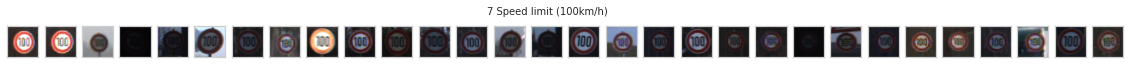

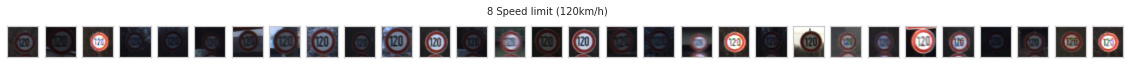

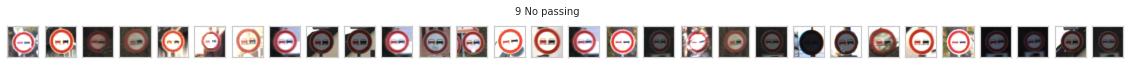

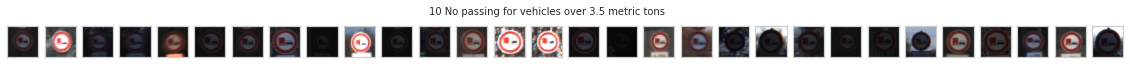

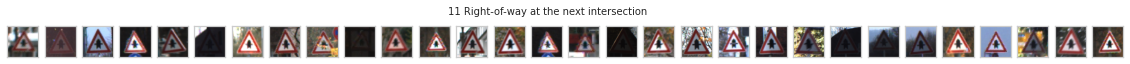

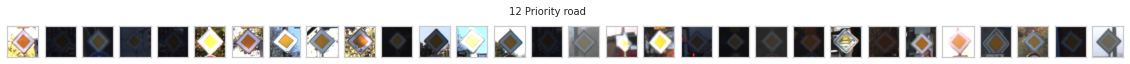

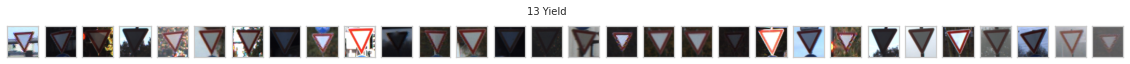

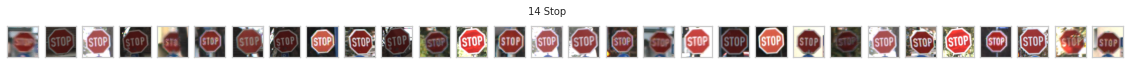

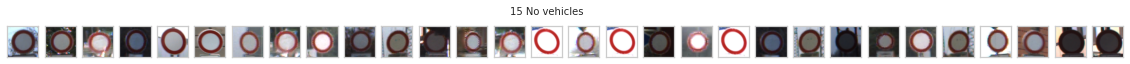

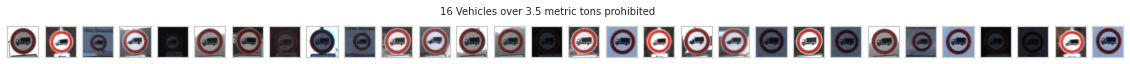

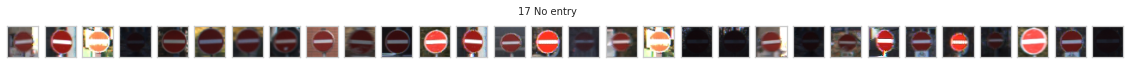

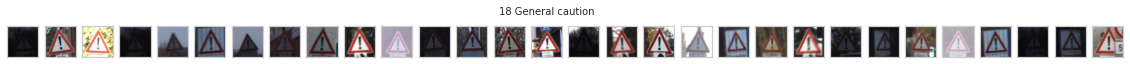

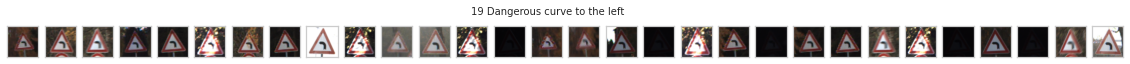

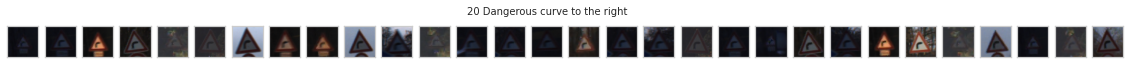

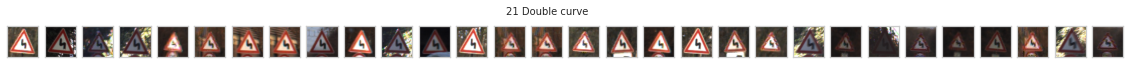

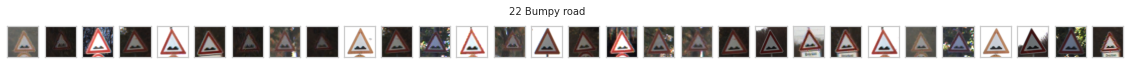

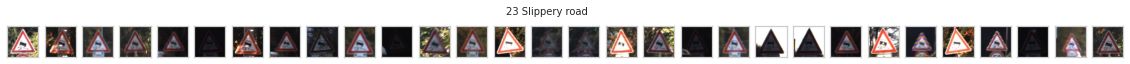

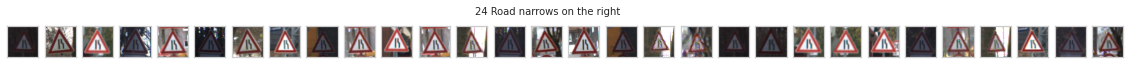

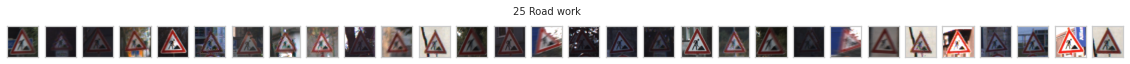

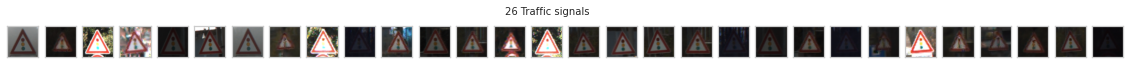

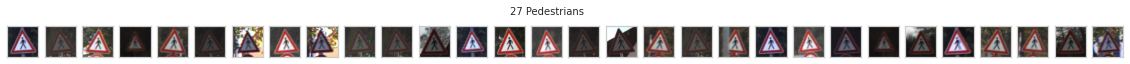

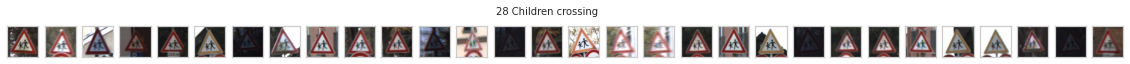

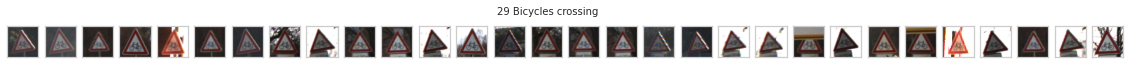

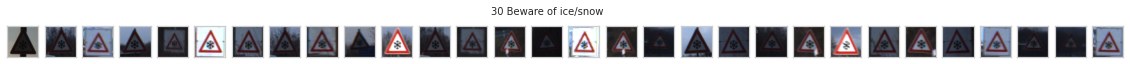

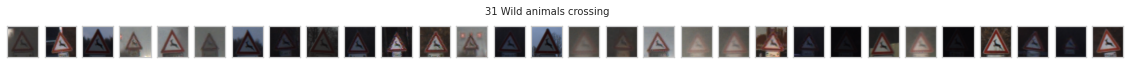

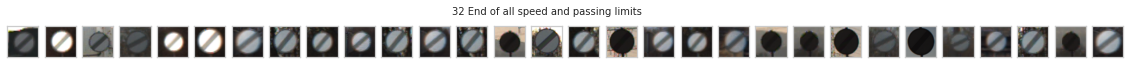

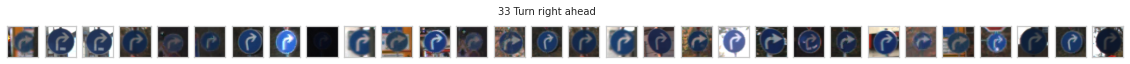

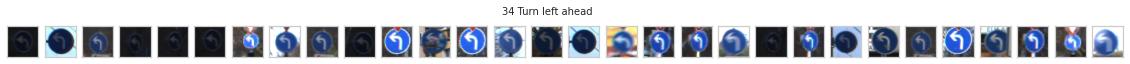

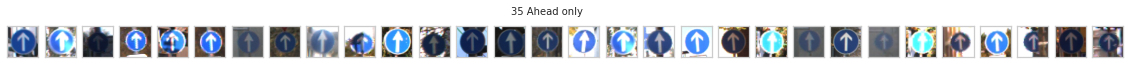

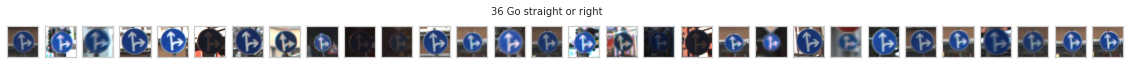

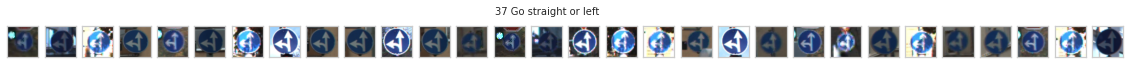

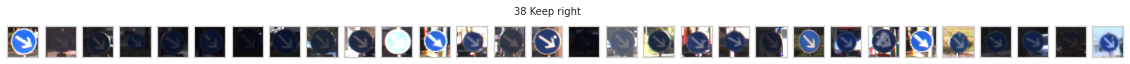

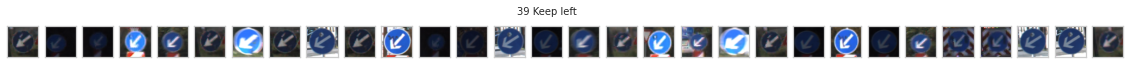

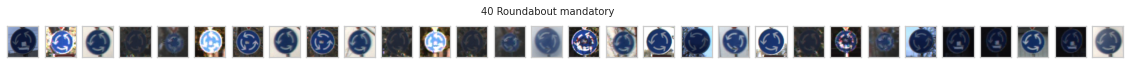

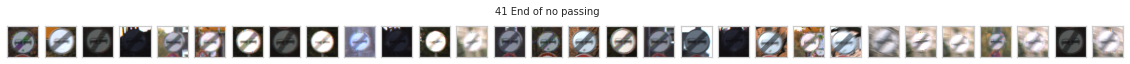

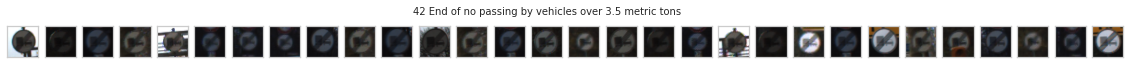

In [6]:
#@title Visualize classes
#@markdown Lets check out 20 random samples of each class. There are several light and focus conditions.
#@markdown Some classes also are very similar, so we can expect the algorithm to confuse between them.

# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

def plot_examples(data,n_samples):
  '''
  Plot n_examples examples from each  
  '''

  # Shuffle data 
  df_labels = pd.DataFrame(data, columns= ['labels']).sample(frac=1)
  df_labels

  for label in class_names:
    
    # Select 20 samples from label
    df = df_labels.loc[df_labels['labels']==label].head(n_samples)

    n = len(df)
    fig, axes = plt.subplots(1,n)
    fig.set_size_inches(20,1)
    fig.suptitle(str(label) + ' ' + class_names[label], fontsize=10)

    # Iterate every sample
    for idx, x in enumerate(df.iterrows()):
      id, row = x
      im = data['features'][id,:,:,:]
      axes[idx].imshow(im)
      axes[idx].axes.xaxis.set_visible(False)
      axes[idx].axes.yaxis.set_visible(False)

plot_examples(data['train'],30)

In [9]:
#@title Fix class imbalance
#@markdown To fix the data imbalance, we perform undersampling on the majority classes.

#!pip install imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler

def undersample(X,y, strategy='not minority'):

  us = RandomUnderSampler(sampling_strategy=strategy)

  # Get subsampled indexes
  idx_us, y_us = us.fit_resample(np.array(range(len(y))).reshape(-1,1),y)

  # Slice features
  X_us=X[idx_us,:,:][:,0,:,:]

  return X_us, y_us

# Define train set
X = data['train']['features']
y = data['train']['labels']

# Undersample
X_train, y_train = undersample(X,y)

# Check class imbalance
df_labels = pd.DataFrame(y_train, columns= ['labels'])
class_counts = df_labels['labels'].value_counts()


# Training

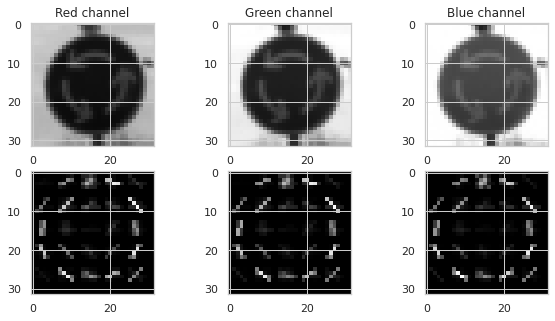

In [10]:
#@title Feature Engineering { run: "auto" }

#@markdown We won't be feeding the images directly to the classifier. Instead we will perform a previous feature extraction as suggested in this paper. https://www.researchgate.net/publication/300918031_Hierarchical_Traffic_Sign_Recognition_Based_on_Multi-feature_and_Multi-classifier_Fusion

#@markdown The histogram of oriented gradients (HOG) is a feature descriptor commonly used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image

#@markdown As a result, an image can be represented as a linear feature vector containing spatial information of each channel. 

#@markdown Number of orientations to be detected
orient = 7 #@param {type:"slider", min:5, max:9, step:2}

#@markdown Pixels per cell
ppc = 6 #@param {type:"slider", min:4, max:8, step:2}

#@markdown Cells per block (for normalization)
cpb = 4 #@param {type:"slider", min:3, max:5, step:1}

import numpy as np
from skimage.io import imread
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

#Avoid warnings 
plt.rcParams.update({'figure.max_open_warning': 0})

#im_rgb = exposure.equalize_hist(signimages['features'][30073])

im = data['train']['features'][4439]

im_r = np.stack([im[:,:,0], im[:,:,0], im[:,:,0]], axis= 2)
im_g = np.stack([im[:,:,1], im[:,:,1], im[:,:,1]], axis= 2)
im_b = np.stack([im[:,:,2], im[:,:,2], im[:,:,2]], axis= 2)


feat_r, hog_image_r = hog(im[:,:,0], orientations=orient, pixels_per_cell=(ppc , ppc),
                	cells_per_block=(cpb, cpb), visualize=True, multichannel=False,feature_vector=True)


feat_g, hog_image_g = hog(im[:,:,1], orientations=orient, pixels_per_cell=(ppc , ppc),
                	cells_per_block=(cpb, cpb), visualize=True, multichannel=False,feature_vector=True)


feat_b, hog_image_b = hog(im[:,:,2], orientations=orient, pixels_per_cell=(ppc , ppc),
                	cells_per_block=(cpb, cpb), visualize=True, multichannel=False,feature_vector=True)

feat, hog_image = hog(im, orientations=orient, pixels_per_cell=(ppc , ppc),
                	cells_per_block=(cpb, cpb), visualize=True, multichannel=True,feature_vector=True)


fig, axes = plt.subplots(2,3)
fig.set_size_inches(10,5)

axes[0,0].imshow(im_r, cmap="gray")
axes[0,0].set_title('Red channel')
axes[0,1].imshow(im_g, cmap="gray")
axes[0,1].set_title('Green channel')
axes[0,2].imshow(im_b, cmap="gray")
axes[0,2].set_title('Blue channel')

axes[1,0].imshow(hog_image_r, cmap="gray")
axes[1,1].imshow(hog_image_g, cmap="gray")
axes[1,2].imshow(hog_image_b, cmap="gray")


In [11]:
#@title Pipeline Helper

# Code taken from: 
# https://github.com/bmurauer/pipelinehelper/tree/master/pipelinehelper

from collections import defaultdict
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin
from sklearn.model_selection import ParameterGrid
from sklearn.utils.metaestimators import if_delegate_has_method

class PipelineHelper(BaseEstimator, TransformerMixin, ClassifierMixin):
    """
    This class can be used in scikit pipelines to select elements.
    In addition to the "replace_estimator" functionality of scikit itself,
    this class allows to set specified parameters for each option in the list.
    """

    def __init__(
            self,
            available_models=None,
            selected_model=None,
            include_bypass=False,
            optional=False,
    ):
        """
        Selects elements from a list to use as estimators in a pipeline.
        Args:
            available_models: a list of models which should be selected from.
                If you have time on your hands, please enable the use of
                pipelines here.
            selected_model: this parameter is required for the clone operation
                used by gridsearch. It should only be used initially if no grid
                search is used.
            optional: if set to true, one of the resulting configurations will
                have this stage empty.
        """
        self.optional = optional
        # this is required for the clone operator used in gridsearch
        self.selected_model = selected_model

        # cloned
        if type(available_models) == dict:
            self.available_models = available_models
        else:
            # manually initialized
            self.available_models = {}
            for (key, model) in available_models:
                self.available_models[key] = model

    def generate(self, param_dict=None):
        """
        Generates the parameters that are required for a gridsearch.
        Args:
            param_dict: parameters for the available models provided in the
                constructor. Note that these don't require the prefix path of
                all elements higher up the hierarchy of this TransformerPicker.
        """
        if param_dict is None:
            param_dict = dict()
        per_model_parameters = defaultdict(lambda: defaultdict(list))

        # collect parameters for each specified model
        for k, values in param_dict.items():
            # example:  randomforest__n_estimators
            model_name = k.split('__')[0]
            param_name = k[len(model_name) + 2:]
            if model_name not in self.available_models:
                raise Exception('no such model: {0}'.format(model_name))
            per_model_parameters[model_name][param_name] = values

        ret = []

        # create instance for cartesion product of all available parameters
        # for each model
        for model_name, param_dict in per_model_parameters.items():
            parameter_sets = ParameterGrid(param_dict)
            for parameters in parameter_sets:
                ret.append((model_name, parameters))

        # for every model that has no specified parameters, add default value
        for model_name in self.available_models.keys():
            if model_name not in per_model_parameters:
                ret.append((model_name, dict()))

        if self.optional:
            ret.append((None, dict()))
        return ret

    def get_params(self, deep=True):
        """
        Returns the parameters of the current TransformerPicker instance.
        Note that this is different from the parameters used by the selected
        model. Provided for scikit estimator compatibility.
        """
        result = {
            'available_models': self.available_models,
            'selected_model': self.selected_model,
            'optional': self.optional,
        }
        if deep and self.selected_model:
            result.update({
                'selected_model__' + k: v
                for k, v in self.selected_model.get_params(deep=True).items()
            })
        if deep and self.available_models:
            for name, model in self.available_models.items():
                result['available_models__' + name] = model
                result.update({
                    'available_models__' + name + '__' + k: v
                    for k, v in model.get_params(deep=True).items()
                })
        return result

    @property
    def transformer_list(self):
        """
        Returns a list of all available models.
        Provided for scikit estimator compatibility.
        """
        return self.available_models

    def set_params(self,
                   selected_model,
                   available_models=None,
                   optional=False):
        """
        Sets the parameters to all available models.
        Provided for scikit estimator compatibility.
        """
        if available_models:
            self.available_models = available_models

        if selected_model[0] is None:
            self.selected_model = None
        else:
            if selected_model[0] not in self.available_models:
                raise ValueError(
                    'trying to set selected model {selected_model[0]}, which '
                    f'is not in the available models {available_models}.'
                )
            self.selected_model = self.available_models[selected_model[0]]
            if self.selected_model is not None:
                self.selected_model.set_params(**selected_model[1])
        return self

    def fit(self, x, y=None, **kwargs):
        """Fits the selected model."""
        if self.selected_model is None or self.selected_model == 'passthrough':
            return self
        else:
            return self.selected_model.fit(x, y, **kwargs)

    def transform(self, x, *args, **kwargs):
        """Transforms data with the selected model."""
        if self.selected_model is None or self.selected_model == 'passthrough':
            return x
        else:
            return self.selected_model.transform(x, *args, **kwargs)

    def predict(self, x):
        """Predicts data with the selected model."""
        if self.optional:
            raise ValueError('a classifier can not be optional')
        return self.selected_model.predict(x)

    @if_delegate_has_method(delegate='selected_model')
    def predict_proba(self, x):
        return self.selected_model.predict_proba(x)

    @if_delegate_has_method(delegate='selected_model')
    def decision_function(self, x):
        return self.selected_model.decision_function(x)

    @property
    def classes_(self):
        if hasattr(self.selected_model, 'classes_'):
            return self.selected_model.classes_
        raise ValueError('selected model does not provide classes_')

In [12]:
#@title Define HOG transformer
#@markdown We define a HOG transformer class to be added to the model pipeline.

from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

class HOGTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, orientations = 5, pixels_per_cell = 4, cells_per_block = 3 ):
      self.orientations = orientations 
      self.pixels_per_cell = pixels_per_cell
      self.cells_per_block = cells_per_block 

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

      # Initialize return vector  
      X_ret = []

      # Iterate over samples and apply hog transform
      for x in X:
        feat= hog(x, 
                  orientations=self.orientations, 
                  pixels_per_cell=(self.pixels_per_cell , self.pixels_per_cell),
                  cells_per_block=(self.cells_per_block, self.cells_per_block), 
                  visualize=False, 
                  multichannel=True,
                  feature_vector=True)
          
        X_ret.append(feat)

      return np.array(X_ret)

In [110]:
#@title Models: Train all

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Preprocess
hogt = HOGTransformer()
pca = PCA()

# classifiers
logr = LogisticRegression(max_iter=500,multi_class='multinomial')
knn= KNeighborsClassifier()
rfc = RandomForestClassifier()
svc = SVC(kernel='linear', decision_function_shape='ovo')
dtc = DecisionTreeClassifier()

# Define pipeline
pipe = Pipeline(steps = [
        ('hogt', hogt),
        ('pca', pca),
    ('classifier', PipelineHelper([
        ('logr',logr),
        ('dtc',dtc),
        ('svc', svc),
        ('knn',knn),
        ('rfc', rfc),
    ])),
])

# Define parameters
params = {
          'hogt__orientations': [7],
          'hogt__pixels_per_cell': [4],
          'pca__n_components': [250],
          'classifier__selected_model': pipe.named_steps['classifier'].generate({
              'logr__C': [1],
              'dtc__max_depth': [100],
              'svc__C': [1],
              'knn__n_neighbors': [15],
          })
}

# Define Metrics
scoring = ['accuracy','f1_micro']

# Grid search
gs = GridSearchCV(pipe,
                  param_grid=params,
                  scoring=scoring,
                  refit='f1_micro',
                  cv=5, 
                  return_train_score=True,
                  verbose=4)

# Fit grid search
gs.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250, accuracy=(train=0.998, test=0.948), f1_micro=(train=0.998, test=0.948), total=  23.5s
[CV] classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.0s remaining:    0.0s


[CV]  classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250, accuracy=(train=0.998, test=0.955), f1_micro=(train=0.998, test=0.955), total=  23.5s
[CV] classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250, accuracy=(train=0.998, test=0.955), f1_micro=(train=0.998, test=0.955), total=  23.9s
[CV] classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


[CV]  classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250, accuracy=(train=0.998, test=0.951), f1_micro=(train=0.998, test=0.951), total=  24.0s
[CV] classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250 
[CV]  classifier__selected_model=('logr', {'C': 1}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250, accuracy=(train=0.998, test=0.949), f1_micro=(train=0.998, test=0.949), total=  24.1s
[CV] classifier__selected_model=('dtc', {'max_depth': 100}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250 
[CV]  classifier__selected_model=('dtc', {'max_depth': 100}), hogt__orientations=7, hogt__pixels_per_cell=4, pca__n_components=250, accuracy=(train=0.990, test=0.594), f1_micro=(train=0.990, test=0.594), total=  19.3s
[CV] classifier__selected_model=('dtc', {'max_depth': 100}), hogt__orientations=7, hogt__pixels_per_cell=4, pca

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 16.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('hogt',
                                        HOGTransformer(cells_per_block=3,
                                                       orientations=5,
                                                       pixels_per_cell=4)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('classifier',
                                        PipelineHelper(available_models={'dtc': DecisionTreeClassifier(ccp_al...
             iid='deprecated', n_jobs=None,
             param_grid={'classifier__selected_model': [

In [133]:
#@title Save model results
import pickle
filename = 'all_models_gs.sav'
pickle.dump(gs, open(filename, 'wb'))

In [13]:
#@title Recover model results
import pickle
import wget

!rm -f *.sav
uri = 'https://github.com/fares-mldev/uns-ml2021/raw/main/tp4/model/all_models_gs.sav'
wget.download(uri)

filename = 'all_models_gs.sav'
gs = pickle.load(open(filename, 'rb'))

In [15]:
#@title Compare results { run: "auto" }
#@markdown SVC has the best performance, followed closely by Logistic regression.
#@markdown KNN and Random forest fail to generalize well. 
#@markdown The worst performance goes to Decision Tree. 

# Convert results to dataframe for analisys
df_results = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')
df_results.sort_values(by='mean_test_f1_micro' , ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__selected_model,param_hogt__orientations,param_hogt__pixels_per_cell,param_pca__n_components,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1_micro,split1_test_f1_micro,split2_test_f1_micro,split3_test_f1_micro,split4_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_train_f1_micro,split1_train_f1_micro,split2_train_f1_micro,split3_train_f1_micro,split4_train_f1_micro,mean_train_f1_micro,std_train_f1_micro
2,17.743978,0.193133,5.544160,0.111955,"(svc, {'C': 1})",7,4,250,"{'classifier__selected_model': ('svc', {'C': 1...",0.958656,0.955426,0.949612,0.956072,0.952196,0.954393,0.003154,1,0.999677,0.999839,0.999839,0.999839,1.000000,0.999839,0.000102,0.958656,0.955426,0.949612,0.956072,0.952196,0.954393,0.003154,1,0.999677,0.999839,0.999839,0.999839,1.000000,0.999839,0.000102
0,21.379812,0.261729,2.434802,0.016592,"(logr, {'C': 1})",7,4,250,"{'classifier__selected_model': ('logr', {'C': ...",0.948320,0.954780,0.955426,0.950904,0.948966,0.951680,0.002929,2,0.998224,0.997901,0.998224,0.997578,0.998224,0.998030,0.000258,0.948320,0.954780,0.955426,0.950904,0.948966,0.951680,0.002929,2,0.998224,0.997901,0.998224,0.997578,0.998224,0.998030,0.000258
3,13.261598,0.078250,7.158365,0.165787,"(knn, {'n_neighbors': 15})",7,4,250,"{'classifier__selected_model': ('knn', {'n_nei...",0.890827,0.914083,0.908269,0.910207,0.913437,0.907364,0.008537,3,0.936370,0.932978,0.935239,0.930556,0.933140,0.933656,0.002010,0.890827,0.914083,0.908269,0.910207,0.913437,0.907364,0.008537,3,0.936370,0.932978,0.935239,0.930556,0.933140,0.933656,0.002010
4,30.596938,0.260520,2.466700,0.034656,"(rfc, {})",7,4,250,"{'classifier__selected_model': ('rfc', {}), 'h...",0.874677,0.888243,0.880491,0.888243,0.882429,0.882817,0.005113,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.874677,0.888243,0.880491,0.888243,0.882429,0.882817,0.005113,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,16.893359,0.164180,2.377465,0.024665,"(dtc, {'max_depth': 100})",7,4,250,"{'classifier__selected_model': ('dtc', {'max_d...",0.594315,0.607881,0.600129,0.616279,0.602067,0.604134,0.007460,5,0.989503,0.988534,0.987403,0.989018,0.985788,0.988049,0.001328,0.594315,0.607881,0.600129,0.616279,0.602067,0.604134,0.007460,5,0.989503,0.988534,0.987403,0.989018,0.985788,0.988049,0.001328


In [16]:
#@title Validate with test set { run: "auto" }
#@markdown There seems to be a degree of overfitting since the model performance drops when compared to the train-val sets.

X_test, y_test = undersample(data['test']['features'],
                             data['test']['labels'])
clf = gs.best_estimator_

y_pred=clf.predict(X_test)

calc_metrics(y_test, y_pred)

{'accuracy': 0.8569767441860465,
 'f1_score': 0.8569767441860465,
 'precision': 0.8569767441860465,
 'recall': 0.8569767441860465}

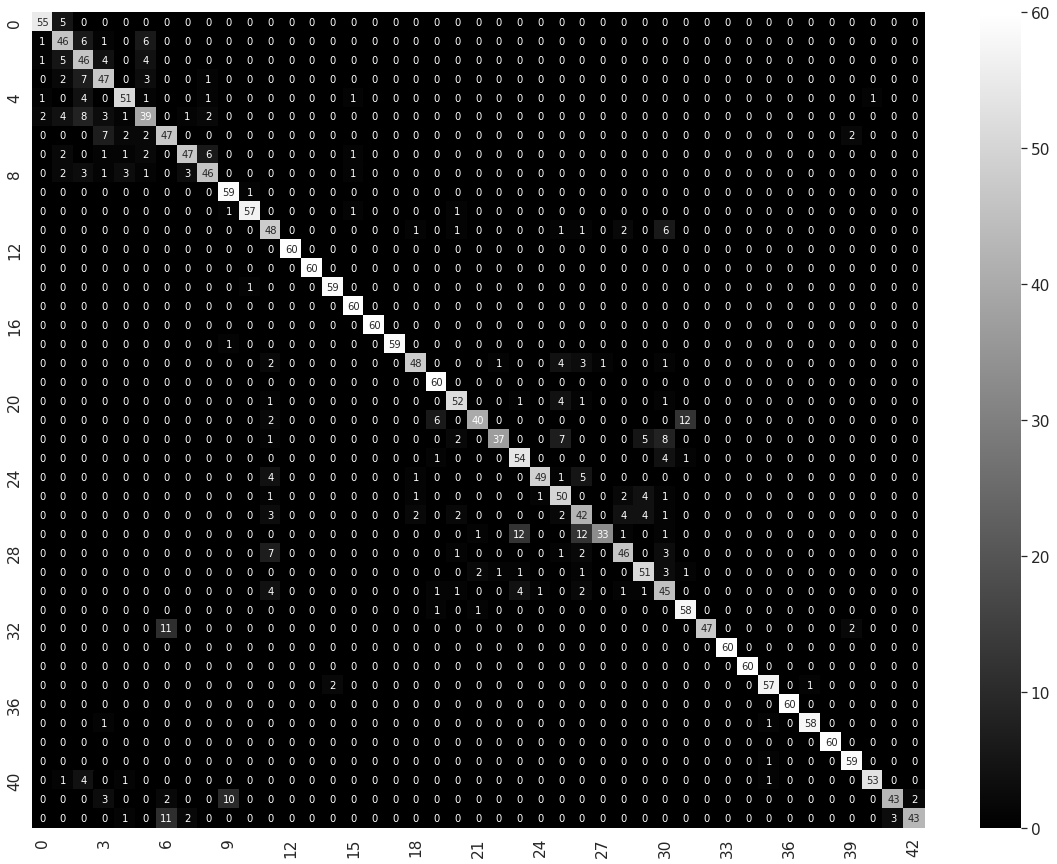

In [17]:
#@title Confusion matrix { run: "auto" }
#@markdown Some classes seem to be harder to classify

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm =  confusion_matrix(y_test, 
                       y_pred,
                       #normalize='true'
                       )
import seaborn as sn

df_cm = pd.DataFrame(cm)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap= 'gray') # font size
fig = plt.gcf()
fig.set_size_inches(20,15)

In [18]:
#@title Error Analysis { run: "auto" }
from sklearn.metrics import classification_report

#@markdown See 5 worst performant classes
cr = classification_report(y_test, y_pred, output_dict = True)
ls_cr = [cr[str(class_id)] for class_id in class_names]
df_cr = pd.DataFrame.from_dict(ls_cr).sort_values(by='f1-score')
df_worst = df_cr.head(5)
idx_worst = df_worst.index

df_worst

,precision,recall,f1-score,support
26,0.608696,0.700000,0.651163,60
5,0.672414,0.650000,0.661017,60
2,0.589744,0.766667,0.666667,60
30,0.608108,0.750000,0.671642,60
27,0.970588,0.550000,0.702128,60


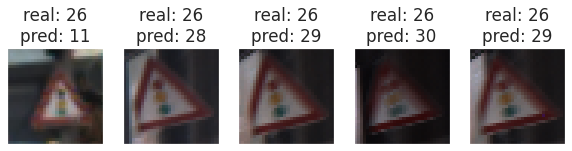

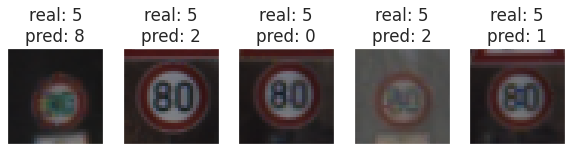

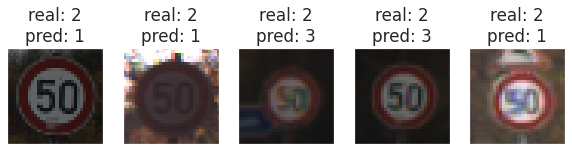

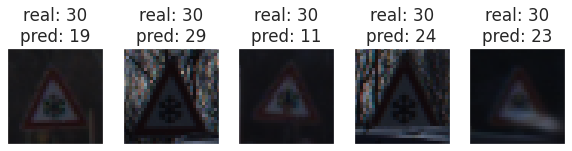

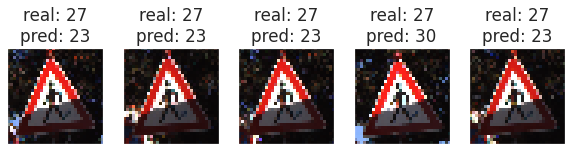

In [19]:
#@title Error Analysis { run: "auto" }
#@markdown Plot some examples of misclassified images

# Identify misclassified samples
y_miss = y_test != y_pred

# Get indexes
idx_miss=np.where(y_miss)

# Get features, real labels and predicted labels
X_miss = X_test[idx_miss]
y_miss = y_test[idx_miss]
y_miss_pred = y_pred[idx_miss]

def plot_class(label):
  # Select misclassified images of selected class
  idx_class = np.array(np.where(y_miss == label)).reshape(-1)

  # Create figure
  n = 5
  fig, axes = plt.subplots(1,n)
  fig.set_size_inches(10,2)

  # Iterate every sample
  for idx in range(n):

    im = X_miss[idx_class][idx]
    axes[idx].imshow(im)
    axes[idx].axes.xaxis.set_visible(False)
    axes[idx].axes.yaxis.set_visible(False)

    title = 'real: ' + str(y_miss[idx_class][idx]) + '\n'
    title += 'pred: ' + str(y_miss_pred[idx_class][idx])

    axes[idx].set_title(title)

# Select a class label
for label in idx_worst:
  plot_class(label)
  